In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve

In [90]:
df = pd.read_csv("data/credit_risk_dataset.csv")

print("Первые пять строк датасета:")
print(df.head())

print("Информация о данных:")
print(df.info())

print("Статистика по численным признакам:")
print(df.describe())

print("Распределение целевого признака:")
print(df['loan_status'].value_counts())

# Вычисляем и выводим долю дефолтов
default_rate = df['loan_status'].mean()
print("Default rate:", default_rate)

Первые пять строк датасета:
   person_age  person_income person_home_ownership  person_emp_length  \
0          22          59000                  RENT              123.0   
1          21           9600                   OWN                5.0   
2          25           9600              MORTGAGE                1.0   
3          23          65500                  RENT                4.0   
4          24          54400                  RENT                8.0   

  loan_intent loan_grade  loan_amnt  loan_int_rate  loan_status  \
0    PERSONAL          D      35000          16.02            1   
1   EDUCATION          B       1000          11.14            0   
2     MEDICAL          C       5500          12.87            1   
3     MEDICAL          C      35000          15.23            1   
4     MEDICAL          C      35000          14.27            1   

   loan_percent_income cb_person_default_on_file  cb_person_cred_hist_length  
0                 0.59                         Y   

In [91]:
# Проверка дубликатов
print("Количество дубликатов:", df.duplicated().sum())

# Удаление дубликатов
df = df.drop_duplicates()
print("Размер таблицы после удаления дубликатов:", df.shape)

# Обработка пропусков с помощью KNNImputer 
from sklearn.impute import KNNImputer

# Проверяем пропуски в нужных числовых столбцах
print("\nПропуски до применения KNNImputer:")
print(df[['person_emp_length', 'loan_int_rate']].isnull().sum())

imputer = KNNImputer(n_neighbors=5)

# Заполняем пропуски только в нужных числовых столбцах
df.loc[:, ['person_emp_length', 'loan_int_rate']] = imputer.fit_transform(
    df[['person_emp_length', 'loan_int_rate']]
)

# Проверяем, что пропусков нет
print("\nПропуски после применения KNNImputer:")
print(df[['person_emp_length', 'loan_int_rate']].isnull().sum())

Количество дубликатов: 165
Размер таблицы после удаления дубликатов: (32416, 12)

Пропуски до применения KNNImputer:
person_emp_length     887
loan_int_rate        3095
dtype: int64

Пропуски после применения KNNImputer:
person_emp_length    0
loan_int_rate        0
dtype: int64


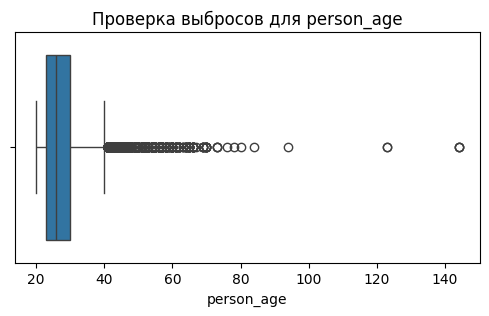

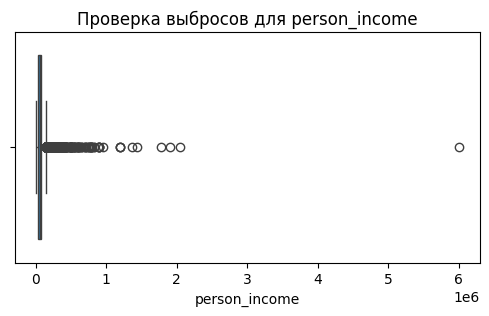

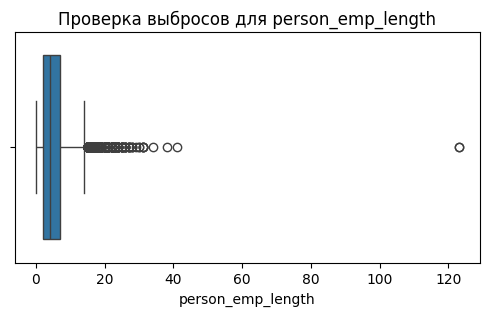

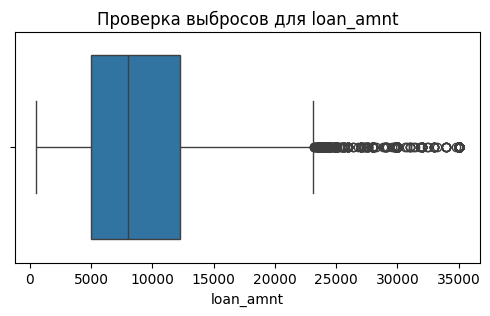

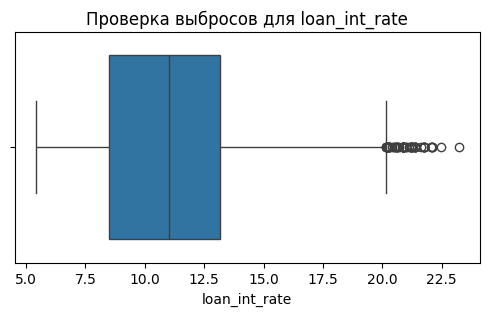

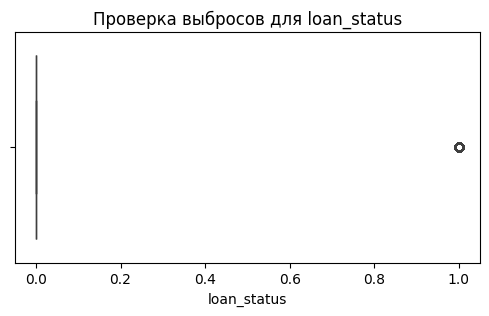

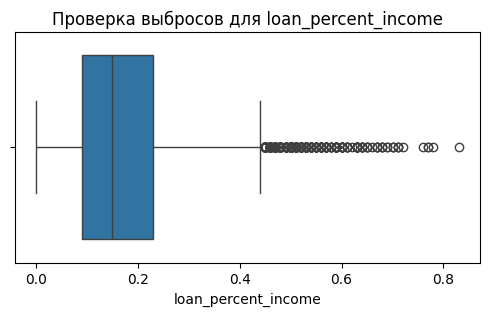

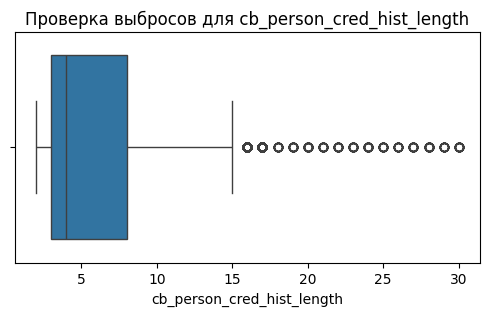

In [92]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Boxplots for visualization
for col in num_cols:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=df[col])
    plt.title(f"Проверка выбросов для {col}")
    plt.show()

In [93]:
# Проверяем строки с нереалистичными значениями ДО очистки
print("Строк с возрастом > 120 (до очистки):", df[df['person_age'] > 120].shape[0])
print("Строк со стажем > 50 лет (до очистки):", df[df['person_emp_length'] > 50].shape[0])

# Удаляем строки с явно неверными значениями
df = df[(df['person_age'] <= 120) & (df['person_emp_length'] <= 50)]

# Проверяем ПОСЛЕ очистки
print("Строк с возрастом > 120 (после очистки):", df[df['person_age'] > 120].shape[0])
print("Строк со стажем > 50 лет (после очистки):", df[df['person_emp_length'] > 50].shape[0])

# Размер таблицы после удаления выбросов
print("Размер таблицы после удаления неверных значений:", df.shape)

Строк с возрастом > 120 (до очистки): 5
Строк со стажем > 50 лет (до очистки): 2
Строк с возрастом > 120 (после очистки): 0
Строк со стажем > 50 лет (после очистки): 0
Размер таблицы после удаления неверных значений: (32409, 12)


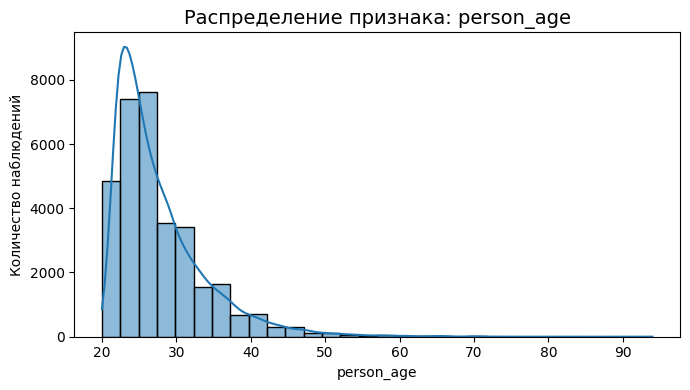

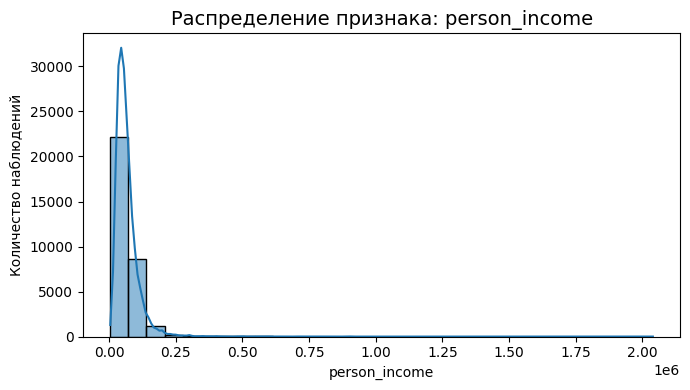

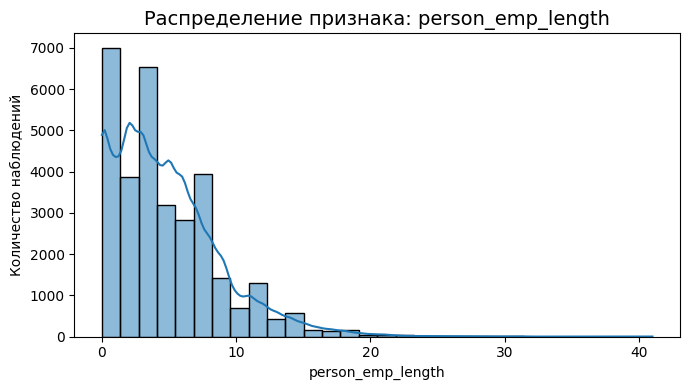

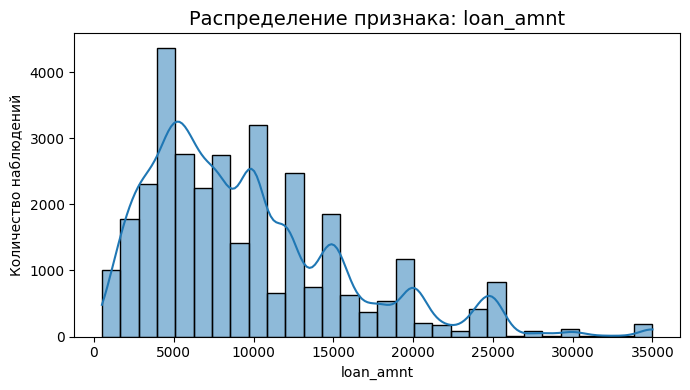

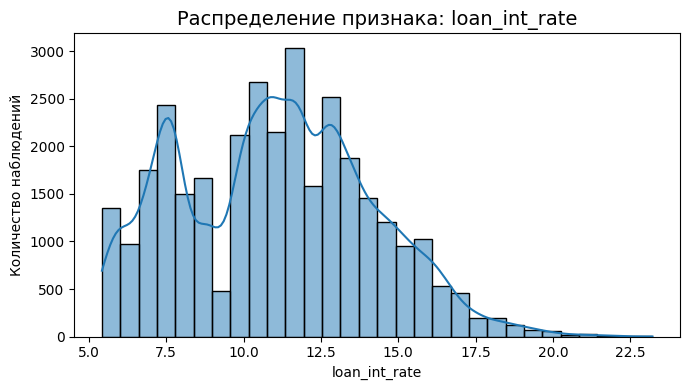

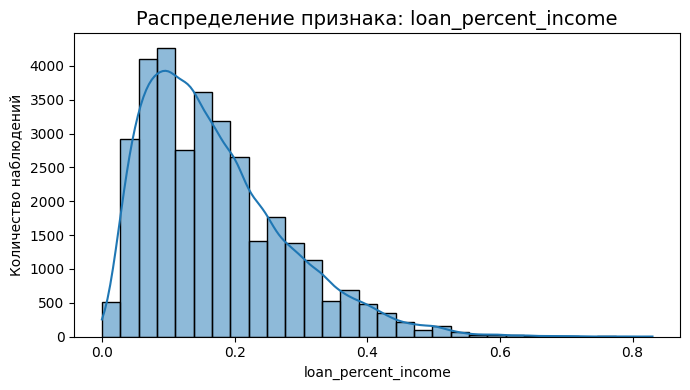

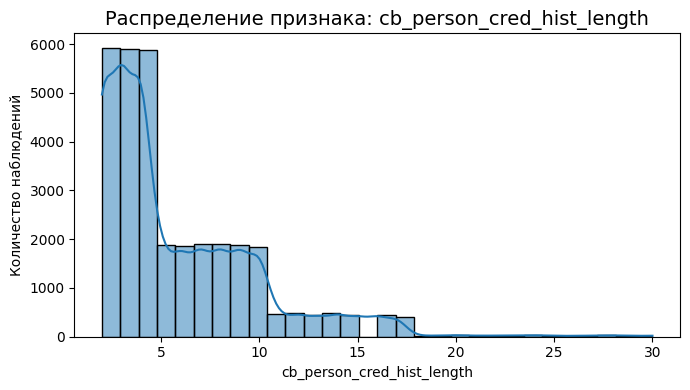

In [94]:
# Список числовых столбцов
num_cols = [
    'person_age',
    'person_income',
    'person_emp_length',
    'loan_amnt',
    'loan_int_rate',
    'loan_percent_income',
    'cb_person_cred_hist_length'
]

# Визуализация распределений
for col in num_cols:
    plt.figure(figsize=(7, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Распределение признака: {col}", fontsize=14)
    plt.xlabel(col)
    plt.ylabel("Количество наблюдений")
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Создаём копию датафрейма для безопасности
df_encoded = df.copy()

binary_cols = ["cb_person_default_on_file", "loan_status"]  
encoders = {}  # словарь для сохранения энкодеров, чтобы при необходимости можно было обратно преобразовать

for col in binary_cols:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col])
    encoders[col] = le

# Кодирование многоклассовых признаков с помощью One-Hot Encoding
multi_cols = ["person_home_ownership", "loan_intent", "loan_grade"]
df_encoded = pd.get_dummies(df_encoded, columns=multi_cols, drop_first=True)

# Выводим информацию о категориальных признаках
for col in multi_cols:
    unique_vals = df[col].unique()

print("\nПример преобразованного датафрейма:")
print(df_encoded.head())

print("\nРазмер датафрейма после кодирования:", df_encoded.shape)


Пример преобразованного датафрейма:
   person_age  person_income  person_emp_length  loan_amnt  loan_int_rate  \
1          21           9600                5.0       1000          11.14   
2          25           9600                1.0       5500          12.87   
3          23          65500                4.0      35000          15.23   
4          24          54400                8.0      35000          14.27   
5          21           9900                2.0       2500           7.14   

   loan_status  loan_percent_income  cb_person_default_on_file  \
1            0                 0.10                          0   
2            1                 0.57                          0   
3            1                 0.53                          0   
4            1                 0.55                          1   
5            1                 0.25                          0   

   cb_person_cred_hist_length  person_home_ownership_OTHER  ...  \
1                           2       

In [96]:
# Features и target
X = df_encoded.drop("loan_status", axis=1)
y = df_encoded["loan_status"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Размер обучающей выборки:", X_train.shape)
print("Размер тестовой выборки:", X_test.shape)

# Масштабируем только числовые признаки
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

Размер обучающей выборки: (25927, 22)
Размер тестовой выборки: (6482, 22)


In [97]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Обучение моделей
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Дерево решений
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)
# Случайный лес
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)
# Градиентный бустинг с XGBoost
xgb = XGBClassifier(eval_metric="logloss", random_state=42)
xgb.fit(X_train_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [98]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1] if hasattr(model, "predict_proba") else None
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob) if y_prob is not None else "N/A"
    
    print(f"\n===== {name} =====")
    print(f"Точность (Accuracy)       : {acc:.4f}")
    print(f"Точность положительных (Precision) : {prec:.4f}")
    print(f"Полнота (Recall)          : {rec:.4f}")
    print(f"F1-score                  : {f1:.4f}")
    print(f"ROC-AUC                   : {roc:.4f}" if roc != "N/A" else "ROC-AUC: N/A")

In [99]:
for name, model in [("Logistic Regression", log_reg),
                    ("Decision Tree", dt),
                    ("Random Forest", rf),
                    ("XGBoost", xgb)]:
    evaluate_model(name, model, X_test_scaled, y_test)


===== Logistic Regression =====
Точность (Accuracy)       : 0.8633
Точность положительных (Precision) : 0.7568
Полнота (Recall)          : 0.5529
F1-score                  : 0.6390
ROC-AUC                   : 0.8704

===== Decision Tree =====
Точность (Accuracy)       : 0.8843
Точность положительных (Precision) : 0.7158
Полнота (Recall)          : 0.7814
F1-score                  : 0.7471
ROC-AUC                   : 0.8472

===== Random Forest =====
Точность (Accuracy)       : 0.9349
Точность положительных (Precision) : 0.9628
Полнота (Recall)          : 0.7306
F1-score                  : 0.8308
ROC-AUC                   : 0.9359

===== XGBoost =====
Точность (Accuracy)       : 0.9364
Точность положительных (Precision) : 0.9523
Полнота (Recall)          : 0.7468
F1-score                  : 0.8372
ROC-AUC                   : 0.9491


In [100]:
results = []

for name, model in [("Logistic Regression", log_reg),
                    ("Decision Tree", dt),
                    ("Random Forest", rf),
                    ("XGBoost", xgb)]:
    
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1] if hasattr(model, "predict_proba") else None
    
    results.append({
        "Модель": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob) if y_prob is not None else None
    })

df_results = pd.DataFrame(results)
print("\nСводка результатов всех моделей:")
print(df_results)


Сводка результатов всех моделей:
                Модель  Accuracy  Precision    Recall  F1-Score   ROC-AUC
0  Logistic Regression  0.863314   0.756757  0.552891  0.638957  0.870360
1        Decision Tree  0.884295   0.715762  0.781382  0.747134  0.847247
2        Random Forest  0.934897   0.962825  0.730606  0.830794  0.935867
3              XGBoost  0.936439   0.952338  0.746827  0.837154  0.949082


In [101]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'n_estimators': [100, 150, 200, 300],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_scaled, y_train)

print("\nЛучшие параметры XGBoost:", random_search.best_params_)
print("Лучший результат на кросс-валидации:", random_search.best_score_)

/Users/iamdamir/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [20:26:36] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/iamdamir/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [20:26:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/iamdamir/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [20:26:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/iamdamir/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [20:26:37] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.


Лучшие параметры XGBoost: {'subsample': 0.8, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.1, 'colsample_bytree': 0.6}
Лучший результат на кросс-валидации: 0.9333514941383987


In [102]:
best_model = random_search.best_estimator_
print("Тип модели:", type(best_model).__name__)
evaluate_model("Тuned Best Model", best_model, X_test_scaled, y_test)

Тип модели: XGBClassifier

===== Тuned Best Model =====
Точность (Accuracy)       : 0.9384
Точность положительных (Precision) : 0.9636
Полнота (Recall)          : 0.7468
F1-score                  : 0.8415
ROC-AUC                   : 0.9510


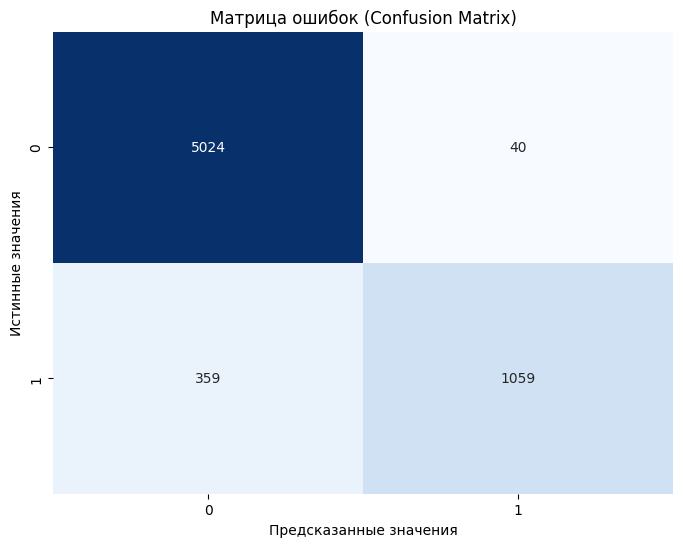

In [103]:
from sklearn.metrics import confusion_matrix

y_pred = best_model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Предсказанные значения")
plt.ylabel("Истинные значения")
plt.title("Матрица ошибок (Confusion Matrix)")
plt.show()

# Матрица ошибок (Confusion Matrix) – разбор

1. **True Negatives (TN = 5024)**  
   - Клиенты, которые не дефолтные (класс 0), модель правильно предсказала как не дефолтные.  
   - Очень высокая точность для невиновных клиентов → мало ложных тревог.

2. **False Positives (FP = 40)**  
   - Клиенты, которые на самом деле не дефолтные, но модель ошибочно предсказала их как дефолтные.  
   - Небольшое количество ошибок, что хорошо для бизнеса — меньше лишних отказов в кредитовании.

3. **False Negatives (FN = 359)**  
   - Клиенты, которые на самом деле дефолтные, но модель ошибочно предсказала их как надёжные.  
   - Это критичная ошибка для банка, потому что пропускаются потенциальные дефолты.

4. **True Positives (TP = 1059)**  
   - Клиенты, которые действительно дефолтные, и модель правильно их выявила.  
   - Модель неплохо ловит дефолтных клиентов, но можно улучшить Recall (чтобы меньше пропусков FN).

/Users/iamdamir/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [20:26:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/iamdamir/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [20:26:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/iamdamir/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [20:26:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/iamdamir/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [20:26:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.

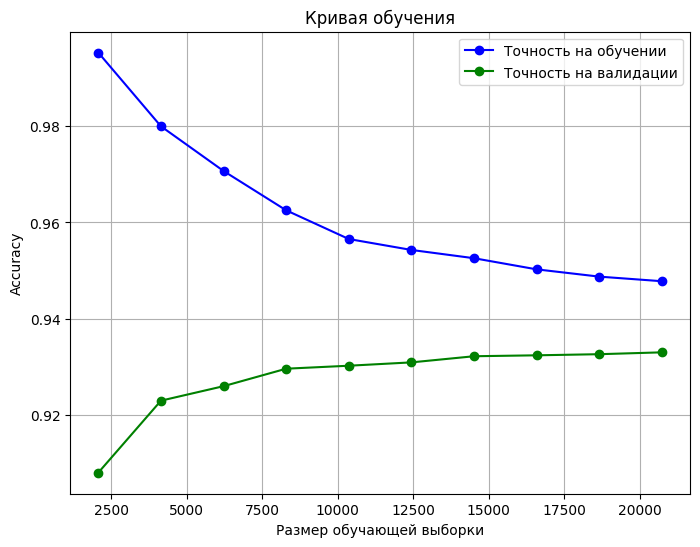

In [104]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_scaled, y_train, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Точность на обучении')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Точность на валидации')
plt.title('Кривая обучения')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Интерпретация кривой обучения (Learning Curve)

- По мере увеличения размера обучающей выборки точность модели на тренировочных данных постепенно снижается с почти 100% до примерно 96%, что указывает на **уменьшение переобучения**.
- В то же время точность на валидации стабильно растёт с ~91.5% до 93.3%, показывая **лучшее обобщение на новых данных**.
- Сужение разрыва между точностью на тренировке и валидации говорит о том, что модель **менее специализирована под обучающие данные** и становится более способной работать с реальными примерами при увеличении объёма данных.
- Эти закономерности подчёркивают пользу использования **больших наборов данных** для повышения производительности модели и указывают на потенциальную необходимость **дополнительной регуляризации**, чтобы ещё больше сократить разрыв в точности.

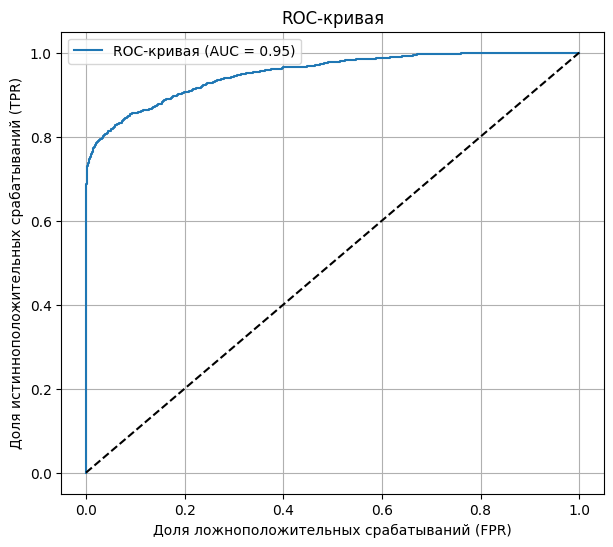

In [105]:
y_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # диагональ (случайное угадывание)
plt.xlabel('Доля ложноположительных срабатываний (FPR)')
plt.ylabel('Доля истинноположительных срабатываний (TPR)')
plt.title('ROC-кривая')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Интерпретация ROC-кривой

- ROC-кривая показывает, насколько хорошо модель различает **положительный** и **отрицательный** классы при разных порогах.
- В данном случае **AUC = 0.95**, что свидетельствует о **отличной производительности модели**.
- Кривая расположена близко к верхнему левому углу, что означает, что модель достигает **высокого True Positive Rate** при **низком False Positive Rate**.
- Диагональная линия соответствует случайному угадыванию (**AUC = 0.5**). Поскольку наша кривая значительно выше диагонали, модель работает намного лучше случайного выбора.
- **AUC = 0.95** также означает, что есть 95% вероятность, что модель правильно ранжирует случайно выбранный положительный пример выше, чем случайно выбранный отрицательный.

In [106]:
df_reconstructed = df_encoded.copy()

for col, le in encoders.items():
    df_reconstructed[col] = le.inverse_transform(df_reconstructed[col])

for col in ["person_home_ownership", "loan_intent", "loan_grade"]:
    onehot_cols = [c for c in df_reconstructed.columns if c.startswith(col + "_")]
    if onehot_cols:
        df_reconstructed[col] = df_reconstructed[onehot_cols].idxmax(axis=1).str.replace(col + "_", "")
        df_reconstructed.drop(columns=onehot_cols, inplace=True)

In [107]:
df_reconstructed.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership,loan_intent,loan_grade
1,21,9600,5.0,1000,11.14,0,0.10,N,2,OWN,EDUCATION,B
2,25,9600,1.0,5500,12.87,1,0.57,N,3,OTHER,MEDICAL,C
3,23,65500,4.0,35000,15.23,1,0.53,N,2,RENT,MEDICAL,C
4,24,54400,8.0,35000,14.27,1,0.55,Y,4,RENT,MEDICAL,C
5,21,9900,2.0,2500,7.14,1,0.25,N,2,OWN,VENTURE,B


In [108]:
df_reconstructed[num_cols] = scaler.inverse_transform(df_reconstructed[num_cols])

df_reconstructed.head()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership,loan_intent,loan_grade
1,157.141769,5.044336e+08,24.685296,6.303162e+06,45.691963,0,0.180973,N,13.871359,OWN,EDUCATION,B
2,181.798886,5.044336e+08,8.769608,3.462427e+07,51.070595,1,0.231132,N,17.911485,OTHER,MEDICAL,C
3,169.470327,3.441325e+09,20.706374,2.202849e+08,58.407919,1,0.226863,N,13.871359,RENT,MEDICAL,C
4,175.634606,2.858150e+09,36.622061,2.202849e+08,55.423245,1,0.228997,Y,21.951612,RENT,MEDICAL,C
5,157.141769,5.201951e+08,12.748530,1.574353e+07,33.255821,1,0.196981,N,13.871359,OWN,VENTURE,B


In [109]:
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [110]:
# Load model
with open("best_model.pkl", "rb") as f:
    loaded_model = pickle.load(f)

print("Model loaded successfully!")

# пример с новыми данными, 2 клиента и 1 с высоким риском
new_data = pd.DataFrame({
    "person_age": [30, 45, 19],
    "person_income": [60000, 85000, 9000],
    "person_emp_length": [10, 20, 0],
    "loan_amnt": [15000, 25000, 20000],
    "loan_int_rate": [12.5, 8.7, 26.1],
    "cb_person_cred_hist_length": [5, 12, 1],
    "person_home_ownership": ["MORTGAGE", "OTHER", "RENT"],
    "loan_intent": ["EDUCATION", "HOMEIMPROVEMENT", "PERSONAL"],
    "loan_grade": ["B", "C", "G"]
})

new_X = pd.get_dummies(new_data)

new_X = new_X.reindex(columns=X_train.columns, fill_value=0)

new_X[num_cols] = scaler.transform(new_X[num_cols])

predictions = loaded_model.predict(new_X)

final_pred = le.inverse_transform(predictions)

for i, p in enumerate(final_pred):
    print(f"Client {i+1} → Prediction: {p}")

Model loaded successfully!
Client 1 → Prediction: 0
Client 2 → Prediction: 0
Client 3 → Prediction: 1
